In [134]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
def f(x):
  return 2*x**2 + 3*x - 4

In [136]:
f(3.0)

23.0

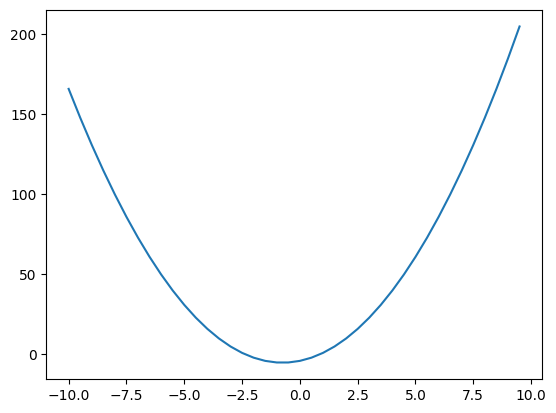

In [137]:
xs = np.arange(-10, 10, 0.5)
ys = f(xs)
plt.plot(xs, ys)

In [138]:
h = 0.0000001
x = -0.75
(f(x + h) - f(x))/h

2.042810365310288e-07

In [139]:
# complex'er case
a = 2.0
b = -3.0
c = 12.0
d = a*b + c
print(d)

6.0


In [140]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 12.0

d1 = a*b + c
c += h
d2 = a*b + c

print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"slope: {(d2 - d1)/h}")

d1: 6.0
d2: 6.0001
slope: 0.9999999999976694


In [141]:
# Value object

class Value:
  def __init__(self, data, _children=(), _op='', label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label


  def __repr__(self):
    return f"Value(data={self.data})"


  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # so constants can be added to Value instances as well
    sum = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * sum.grad
      other.grad += 1.0 * sum.grad
    sum._backward = _backward

    return sum

  # fallback in case of constant + Value
  def __radd__(self, other): # basically: other * self
    return self + other


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    prod = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * prod.grad
      other.grad += self.data * prod.grad

    prod._backward = _backward

    return prod


  # fallback function when doing something like const * Value
  # Python will check if Value can multiply const. if yes, it does rmul
  # instead of mul
  def __rmul__(self, other): # basically: other * self
    return self * other


  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad = other * self.data**(other-1) * out.grad
    out._backward = _backward

    return out


  def __truediv__(self, other):
    return self * other**-1

  def __rtruediv__(self, other):
    return other * self**-1


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out


  def exp(self):
    x = self.data
    exp = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += exp.data * exp.grad # chain rule
    exp._backward = _backward

    return exp


  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [142]:
a = Value(2.0)
b = Value(4.0)
2 + a

Value(data=4.0)

In [143]:
# trying to visualize the graph

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad, ), shape='record')
    if n._op:
      # if this node is a result of some operation, then create an operation node for it
      dot.node(name = uid + n._op, label = n._op)
      # connect this ndoe to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the operation node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [144]:
# backprop to a neuron

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.88137, label='b')

# weighted sum
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()

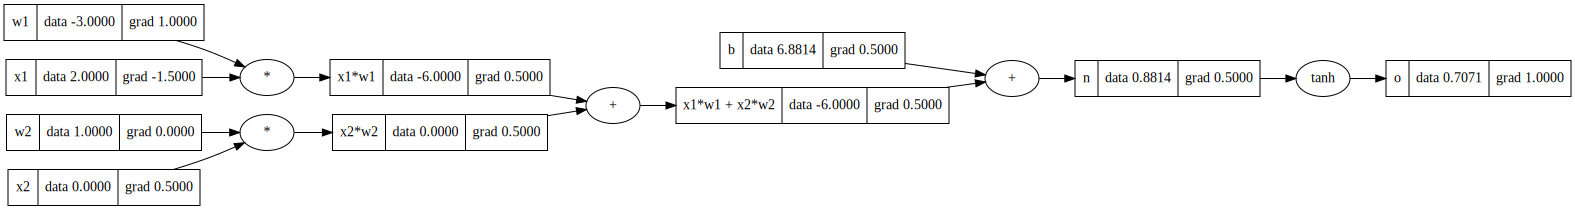

In [145]:
draw_dot(o)

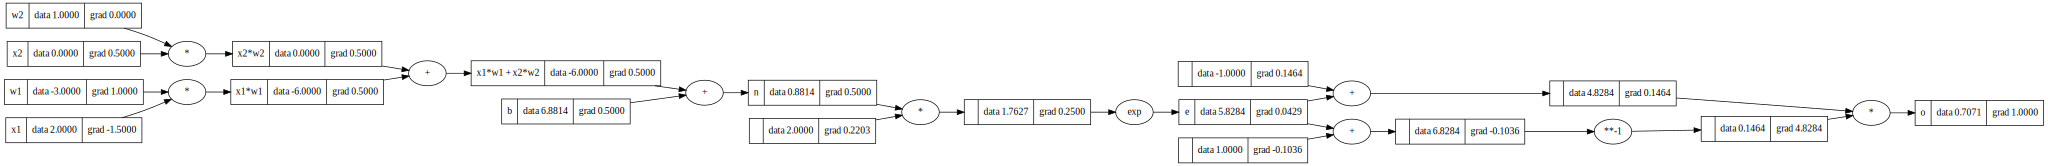

In [146]:
# backprop to a neuron

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.88137, label='b')

# weighted sum
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
# -----
e = (2*n).exp(); e.label='e'
o =  (e - 1) / (e + 1); o.label='o'
# -----
o.backward()
draw_dot(o)

In [147]:
o

Value(data=0.7071049876722272)

In [148]:
# Implementing this in PyTorch

import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True
x2 = torch.tensor([0.0]).double(); x2.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True
b = torch.tensor([6.881373587]).double(); b.requires_grad=True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('----')
print(f"w1: {w1.grad.item()}")
print(f"x1: {x1.grad.item()}")
print(f"x2: {x2.grad.item()}")
print(f"w2: {w2.grad.item()}")

0.7071066904050358
----
w1: 1.0000002567688737
x1: -1.5000003851533106
x2: 0.5000001283844369
w2: 0.0


MLP:

In [149]:
import random

In [150]:
class Neuron:

  def __init__(self, n_in): # num of inputs
    # initialize the weights and bias
    self.w = [Value(random.uniform(-1,1)) for _ in range(n_in)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w*x + b
    activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    output = activation.tanh()
    return output

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, n_in, n_out):
    self.neurons = [Neuron(n_in) for _ in range(n_out)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

  def __init__(self, n_in, n_outs):
    size = [n_in] + n_outs
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_outs))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [151]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.711452907203154)

In [152]:
len(n.parameters())

41

In [153]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [154]:
# training loop

for k in range(1001):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update with GD
  for p in n.parameters():
    p.data -= 0.05 * p.grad

  if k % 100 == 0:
      print(f"epoch: {k}, loss: {loss.data:.4f}")



epoch: 0, loss: 6.5922
epoch: 100, loss: 0.0053
epoch: 200, loss: 0.0025
epoch: 300, loss: 0.0017
epoch: 400, loss: 0.0012
epoch: 500, loss: 0.0010
epoch: 600, loss: 0.0008
epoch: 700, loss: 0.0007
epoch: 800, loss: 0.0006
epoch: 900, loss: 0.0005
epoch: 1000, loss: 0.0005


In [155]:
ypred

[Value(data=0.9923447982903439),
 Value(data=-0.9909434545756738),
 Value(data=-0.9867864366917058),
 Value(data=0.9876006383736393)]

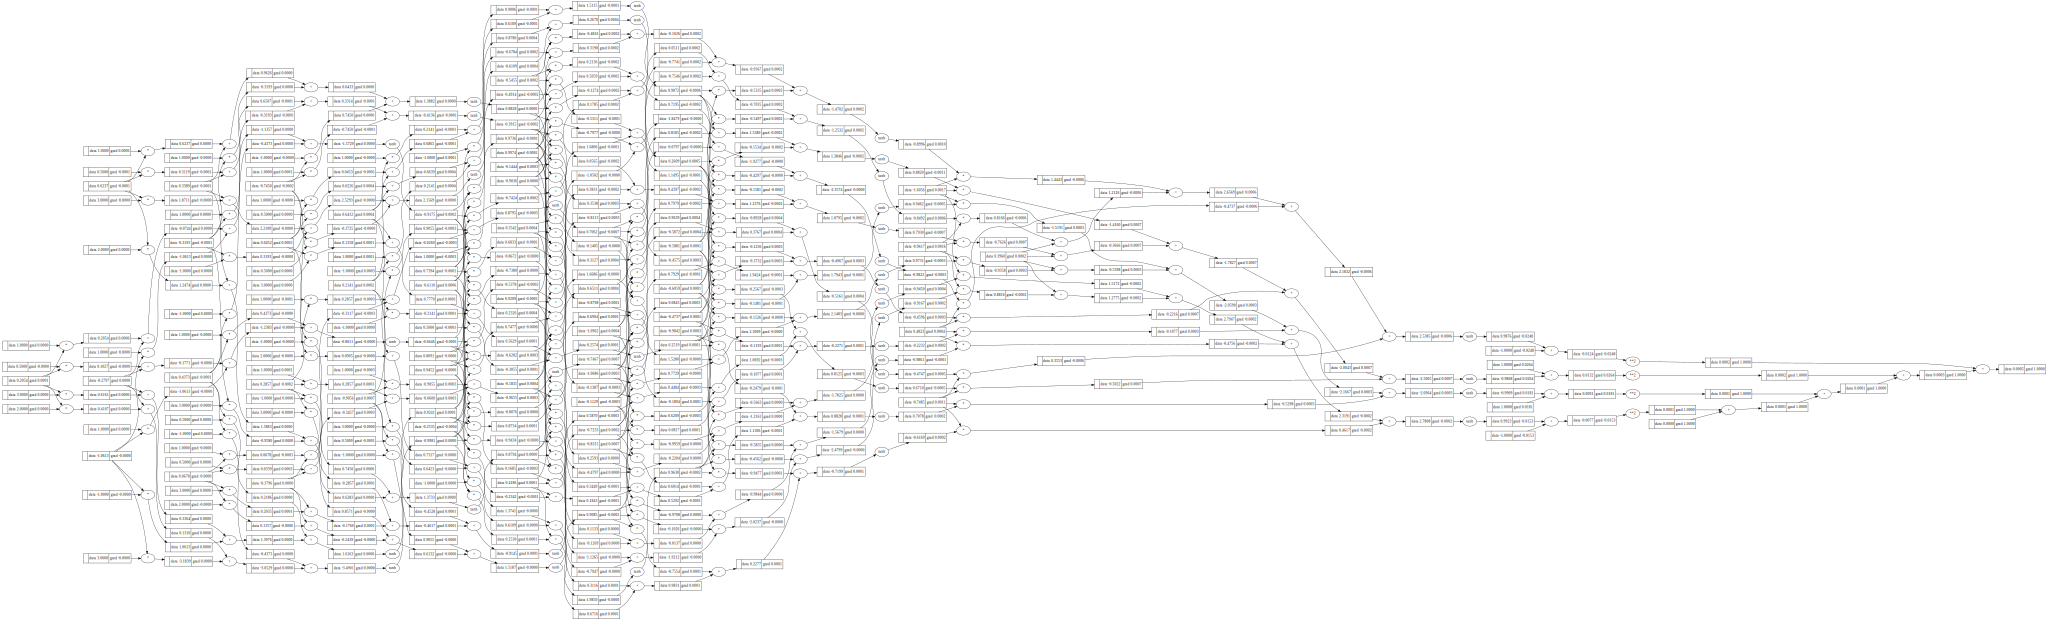

In [156]:
draw_dot(loss)